# Refinement plots

In [1]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.io.read import load_psmlist

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

from denovo_utils.analysis.metrics import (
    get_refinement_error_tables,
    plot_refinement_error_table,
    plot_precision_recall_refinement,
)

import pandas as pd

from pathlib import Path

from denovo_utils.io.read import read_partitions_features, read_partitions_psmlist
from denovo_utils.io.save import save_psmlist

from glob import glob

from denovo_utils.analysis.metrics import create_refinement_alluvial
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import os
from pathlib import Path

2025-08-07 14:12:52.044837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-07 14:12:52.177085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-07 14:12:52.215172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


In [27]:
from denovo_utils.analysis.metrics import calculate_prc
import numpy as np

def calculate_prc(
        n_correct,
        n_selected,
        n_predicted
):
    c = n_correct
    ci = n_selected
    u = n_predicted - ci

    # precision
    precision = c/ci

    # recall (This is an alternative definition and the line will stop at x=y)
    recall = c/n_predicted

    # coverage
    coverage = ci/n_predicted

    return precision, recall, coverage


def get_prc_curve(t, n_predicted = None):
    prs = []
    recs = []
    covs = []

    t = t.sort_values('score', ascending=False).reset_index(drop=True)

    if n_predicted is None:
        n_predicted = len(t)

    for coverage in tqdm(np.linspace(0,1,200)):
        if coverage == 0:
            continue
        n_samples = coverage * len(t)
        samples_evaluated = t[t.index<n_samples]
        
        pr, rec, cov = calculate_prc(
            n_correct=len(samples_evaluated[samples_evaluated.match]),
            n_selected=len(samples_evaluated),
            n_predicted=n_predicted,
        )
        prs.append(pr)
        recs.append(rec)
        covs.append(cov)

    return pd.DataFrame(
        {'precision': prs,
         'recall': recs,
         'coverage': covs}
    )

In [ ]:
def collapse_partitions(root, engines, suffix):
    for root_file in glob(os.path.join(root, '*')):
        for engine in engines:
            psm_path = os.path.join(root_file, 'psmlist')
            f_path = os.path.join(root_file, 'features')

            psmlist = read_partitions_psmlist(psm_path, prefix_filename=f'{engine}_')
            features = read_partitions_features(f_path, prefix_filename=f"{engine}_")

            save_psmlist(
                psm_list=psmlist,
                save_path=os.path.join(psm_path, f'{engine}{suffix}')
            )
            features.to_parquet(os.path.join(f_path, f'{engine}{suffix}'))

collapse_partitions(
    root='/public/compomics3/Sam/PXD028735/QExactive/rescoring',
    engines=['adanovo', 'pihelixnovo', 'piprimenovo'],
    suffix='.instanovoplus.parquet'
)

# 1. Load the data in Run objects

## 1.1 Load de novo results

In [ ]:
# # root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/denovo_output'
# # root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
# # root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'

# root_rescoring = '/public/compomics3/Sam/PXD028735/QExactive/rescoring'

# run_names = [
#     'LFQ_Orbitrap_DDA_Ecoli_01',
#     'LFQ_Orbitrap_DDA_Human_01',
#     'LFQ_Orbitrap_DDA_QC_01',
#     'LFQ_Orbitrap_DDA_Yeast_01'
# ]

# engine_names = [
#     'adanovo',
#     'pihelixnovo',
#     'piprimenovo',
#     'casanovo',
#     'instanovo',
#     'contranovo',
#     'novob',
#     'pepnet',
# ]

# refinement_names = [
#     'spectralis',
#     'instanovoplus'
# ]

# runs = {}
# for run_name in run_names:
#     print(f"Run: {run_name}")
#     run = Run(run_name)

#     gt_path = os.path.join(root_rescoring, run_name, 'psmlist', 'ground_truth.parquet')
#     psmlist_gt = load_psmlist(gt_path)
#     run.load_data(
#         psmlist=psmlist_gt.get_rank1_psms(),
#         score_names=['score_ms2rescore'],
#         is_ground_truth=True
#     )

#     for engine_name in engine_names:
#         print(f'loading {engine_name}')

#         denovo_path = os.path.join(root_rescoring, run_name, 'psmlist', f'{engine_name}.parquet')
#         psmlist_denovo = load_psmlist(denovo_path)
#         run.load_data(
#             psmlist=psmlist_denovo,
#             score_names=['score_ms2rescore'],
#             is_ground_truth=False
#         )
    
#         # load refinement
#         for refinement_name in refinement_names:
#             refinement_path = os.path.join(root_rescoring, run_name, 'psmlist', f'{engine_name}.{refinement_name}.parquet')
#             if os.path.exists(refinement_path):
#                 print(f'    loading {refinement_name}')
#                 psmlist_refinement = load_psmlist(refinement_path)
#                 run.load_refinement(psmlist_refinement)

#     runs[run_name] = run

Run: LFQ_Orbitrap_DDA_Ecoli_01


Loading results from ground_truth.parquet: 100%|██████████| 24285/24285 [00:02<00:00, 8635.15it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 24285/24285 [00:00<00:00, 45616.74it/s]


loading adanovo


Loading results from adanovo.parquet: 100%|██████████| 61843/61843 [00:07<00:00, 7795.42it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61843/61843 [00:00<00:00, 109184.33it/s]


    loading instanovoplus


Loading results from adanovo.instanovoplus.parquet: 100%|██████████| 61832/61832 [00:05<00:00, 10879.71it/s]


loading pihelixnovo


Loading results from pihelixnovo.parquet: 100%|██████████| 61955/61955 [00:05<00:00, 12252.36it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61955/61955 [00:00<00:00, 122774.84it/s]


    loading instanovoplus


Loading results from pihelixnovo.instanovoplus.parquet: 100%|██████████| 61936/61936 [00:05<00:00, 11380.43it/s]


loading piprimenovo


Loading results from piprimenovo.parquet: 100%|██████████| 58682/58682 [00:04<00:00, 12421.95it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 58682/58682 [00:00<00:00, 120937.66it/s]


    loading instanovoplus


Loading results from piprimenovo.instanovoplus.parquet: 100%|██████████| 62099/62099 [00:05<00:00, 11327.86it/s]


loading casanovo


Loading results from casanovo.parquet: 100%|██████████| 61876/61876 [00:07<00:00, 8009.10it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61876/61876 [00:00<00:00, 122503.17it/s]


    loading spectralis


Loading results from casanovo.spectralis.parquet: 100%|██████████| 61876/61876 [00:06<00:00, 9556.60it/s] 


    loading instanovoplus


Loading results from casanovo.instanovoplus.parquet: 100%|██████████| 61866/61866 [00:05<00:00, 11181.52it/s]


loading instanovo


Loading results from instanovo.parquet: 100%|██████████| 61562/61562 [00:05<00:00, 11364.22it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61562/61562 [00:00<00:00, 127778.47it/s]


    loading spectralis


Loading results from instanovo.spectralis.parquet: 100%|██████████| 61562/61562 [00:06<00:00, 9556.57it/s] 


    loading instanovoplus


Loading results from instanovo.instanovoplus.parquet: 100%|██████████| 61557/61557 [00:05<00:00, 11132.40it/s]


loading contranovo


Loading results from contranovo.parquet: 100%|██████████| 30999/30999 [00:03<00:00, 8590.32it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 30999/30999 [00:00<00:00, 114833.22it/s]


    loading spectralis


Loading results from contranovo.spectralis.parquet: 100%|██████████| 31017/31017 [00:03<00:00, 9439.93it/s]


    loading instanovoplus


Loading results from contranovo.instanovoplus.parquet: 100%|██████████| 31015/31015 [00:02<00:00, 11219.16it/s]


loading novob


Loading results from novob.parquet: 100%|██████████| 61479/61479 [00:05<00:00, 10743.95it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61479/61479 [00:07<00:00, 7834.92it/s]  


    loading spectralis


Loading results from novob.spectralis.parquet: 100%|██████████| 61479/61479 [00:06<00:00, 9570.19it/s] 


    loading instanovoplus


Loading results from novob.instanovoplus.parquet: 100%|██████████| 61476/61476 [00:05<00:00, 11256.19it/s]


loading pepnet


Loading results from pepnet.parquet: 100%|██████████| 62560/62560 [00:07<00:00, 8919.09it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 62560/62560 [00:00<00:00, 133295.23it/s]


    loading spectralis


Loading results from pepnet.spectralis.parquet: 100%|██████████| 62559/62559 [00:06<00:00, 9711.72it/s] 


    loading instanovoplus


Loading results from pepnet.instanovoplus.parquet: 100%|██████████| 62557/62557 [00:05<00:00, 11204.24it/s]


Run: LFQ_Orbitrap_DDA_Human_01


Loading results from ground_truth.parquet: 100%|██████████| 90817/90817 [00:10<00:00, 8902.26it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 90817/90817 [00:01<00:00, 48630.77it/s]


loading adanovo


Loading results from adanovo.parquet: 100%|██████████| 115178/115178 [00:14<00:00, 8001.48it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 115178/115178 [00:01<00:00, 58755.47it/s]


    loading instanovoplus


Loading results from adanovo.instanovoplus.parquet: 100%|██████████| 115160/115160 [00:10<00:00, 11291.53it/s]


loading pihelixnovo


Loading results from pihelixnovo.parquet: 100%|██████████| 115417/115417 [00:09<00:00, 12177.11it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 115417/115417 [00:16<00:00, 6916.00it/s] 


    loading instanovoplus


Loading results from pihelixnovo.instanovoplus.parquet: 100%|██████████| 115390/115390 [00:10<00:00, 11293.94it/s]


loading piprimenovo


Loading results from piprimenovo.parquet: 100%|██████████| 111287/111287 [00:09<00:00, 12213.79it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 111287/111287 [00:01<00:00, 57583.15it/s]


    loading instanovoplus


Loading results from piprimenovo.instanovoplus.parquet: 100%|██████████| 115472/115472 [00:10<00:00, 11367.58it/s]


loading casanovo


Loading results from casanovo.parquet: 100%|██████████| 115362/115362 [00:14<00:00, 7966.55it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 115362/115362 [00:02<00:00, 55829.68it/s]


    loading spectralis


Loading results from casanovo.spectralis.parquet: 100%|██████████| 115362/115362 [00:12<00:00, 9571.45it/s]


    loading instanovoplus


Loading results from casanovo.instanovoplus.parquet: 100%|██████████| 115340/115340 [00:10<00:00, 11220.56it/s]


loading instanovo


Loading results from instanovo.parquet: 100%|██████████| 114725/114725 [00:29<00:00, 3898.48it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 114725/114725 [00:01<00:00, 58613.27it/s]


    loading spectralis


Loading results from instanovo.spectralis.parquet: 100%|██████████| 114725/114725 [00:12<00:00, 9510.06it/s]


    loading instanovoplus


Loading results from instanovo.instanovoplus.parquet: 100%|██████████| 114712/114712 [00:10<00:00, 11258.51it/s]


loading contranovo


Loading results from contranovo.parquet: 100%|██████████| 57640/57640 [00:06<00:00, 8648.81it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 57640/57640 [00:01<00:00, 54139.42it/s]


    loading spectralis


Loading results from contranovo.spectralis.parquet: 100%|██████████| 57677/57677 [00:06<00:00, 9518.95it/s] 


    loading instanovoplus


Loading results from contranovo.instanovoplus.parquet: 100%|██████████| 57669/57669 [00:05<00:00, 11269.13it/s]


loading novob


Loading results from novob.parquet: 100%|██████████| 114064/114064 [00:10<00:00, 10798.17it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 114064/114064 [00:01<00:00, 59495.77it/s]


    loading spectralis


Loading results from novob.spectralis.parquet: 100%|██████████| 114063/114063 [00:11<00:00, 9603.11it/s]


    loading instanovoplus


Loading results from novob.instanovoplus.parquet: 100%|██████████| 114060/114060 [00:34<00:00, 3337.45it/s] 


loading pepnet


Loading results from pepnet.parquet: 100%|██████████| 118245/118245 [00:13<00:00, 8925.92it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 118245/118245 [00:01<00:00, 61604.89it/s]


    loading spectralis


Loading results from pepnet.spectralis.parquet: 100%|██████████| 118245/118245 [00:12<00:00, 9653.59it/s]


    loading instanovoplus


Loading results from pepnet.instanovoplus.parquet: 100%|██████████| 118226/118226 [00:10<00:00, 11160.62it/s]


Run: LFQ_Orbitrap_DDA_QC_01


Loading results from ground_truth.parquet: 100%|██████████| 83941/83941 [00:09<00:00, 8962.11it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 83941/83941 [00:01<00:00, 48398.63it/s]


loading adanovo


Loading results from adanovo.parquet: 100%|██████████| 107088/107088 [00:13<00:00, 8100.67it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 107088/107088 [00:01<00:00, 59898.50it/s]


    loading instanovoplus


Loading results from adanovo.instanovoplus.parquet: 100%|██████████| 107060/107060 [00:09<00:00, 11350.56it/s]


loading pihelixnovo


Loading results from pihelixnovo.parquet: 100%|██████████| 107182/107182 [00:08<00:00, 12299.96it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 107182/107182 [00:01<00:00, 56873.11it/s]


    loading instanovoplus


Loading results from pihelixnovo.instanovoplus.parquet: 100%|██████████| 107139/107139 [00:09<00:00, 11374.78it/s]


loading piprimenovo


Loading results from piprimenovo.parquet: 100%|██████████| 103511/103511 [00:08<00:00, 12349.04it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 103511/103511 [00:01<00:00, 58144.55it/s]


    loading instanovoplus


Loading results from piprimenovo.instanovoplus.parquet: 100%|██████████| 107347/107347 [00:09<00:00, 11287.49it/s]


loading casanovo


Loading results from casanovo.parquet: 100%|██████████| 107203/107203 [00:13<00:00, 7994.14it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 107203/107203 [00:01<00:00, 56940.32it/s]


    loading spectralis


Loading results from casanovo.spectralis.parquet: 100%|██████████| 107203/107203 [00:11<00:00, 9142.52it/s]


    loading instanovoplus


Loading results from casanovo.instanovoplus.parquet: 100%|██████████| 107192/107192 [00:10<00:00, 10554.91it/s]


loading instanovo


Loading results from instanovo.parquet: 100%|██████████| 106604/106604 [00:09<00:00, 11432.06it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 106604/106604 [00:01<00:00, 60806.95it/s]


    loading spectralis


Loading results from instanovo.spectralis.parquet: 100%|██████████| 106604/106604 [00:11<00:00, 9622.11it/s]


    loading instanovoplus


Loading results from instanovo.instanovoplus.parquet: 100%|██████████| 106590/106590 [00:09<00:00, 11345.02it/s]


loading contranovo


Loading results from contranovo.parquet: 100%|██████████| 53533/53533 [00:06<00:00, 8730.02it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 53533/53533 [00:00<00:00, 54396.56it/s]


    loading spectralis


Loading results from contranovo.spectralis.parquet: 100%|██████████| 53579/53579 [00:05<00:00, 9672.58it/s] 


    loading instanovoplus


Loading results from contranovo.instanovoplus.parquet: 100%|██████████| 53570/53570 [00:04<00:00, 11309.60it/s]


loading novob


Loading results from novob.parquet: 100%|██████████| 106075/106075 [00:09<00:00, 10859.67it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 106075/106075 [00:01<00:00, 61146.84it/s]


    loading spectralis


Loading results from novob.spectralis.parquet: 100%|██████████| 106075/106075 [00:11<00:00, 9626.07it/s]


    loading instanovoplus


Loading results from novob.instanovoplus.parquet: 100%|██████████| 106070/106070 [00:46<00:00, 2270.99it/s] 


loading pepnet


Loading results from pepnet.parquet: 100%|██████████| 109340/109340 [00:12<00:00, 8969.10it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 109340/109340 [00:01<00:00, 61813.12it/s]


    loading spectralis


Loading results from pepnet.spectralis.parquet: 100%|██████████| 109338/109338 [00:11<00:00, 9766.59it/s]


    loading instanovoplus


Loading results from pepnet.instanovoplus.parquet: 100%|██████████| 109326/109326 [00:09<00:00, 11233.27it/s]


Run: LFQ_Orbitrap_DDA_Yeast_01


Loading results from ground_truth.parquet: 100%|██████████| 67111/67111 [00:07<00:00, 8992.17it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 67111/67111 [00:01<00:00, 54944.53it/s]


loading adanovo


Loading results from adanovo.parquet: 100%|██████████| 102427/102427 [00:12<00:00, 8160.88it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 102427/102427 [00:01<00:00, 80270.97it/s]


    loading instanovoplus


Loading results from adanovo.instanovoplus.parquet: 100%|██████████| 102412/102412 [00:08<00:00, 11440.11it/s]


loading pihelixnovo


Loading results from pihelixnovo.parquet: 100%|██████████| 102483/102483 [00:08<00:00, 12250.78it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 102483/102483 [00:01<00:00, 76409.49it/s]


    loading instanovoplus


Loading results from pihelixnovo.instanovoplus.parquet: 100%|██████████| 102441/102441 [00:08<00:00, 11402.56it/s]


loading piprimenovo


Loading results from piprimenovo.parquet: 100%|██████████| 96975/96975 [00:07<00:00, 12370.61it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 96975/96975 [00:01<00:00, 78375.43it/s] 


    loading instanovoplus


Loading results from piprimenovo.instanovoplus.parquet: 100%|██████████| 102597/102597 [00:08<00:00, 11448.16it/s]


loading casanovo


Loading results from casanovo.parquet: 100%|██████████| 102518/102518 [00:12<00:00, 8195.42it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 102518/102518 [00:01<00:00, 77787.02it/s]


    loading spectralis


Loading results from casanovo.spectralis.parquet: 100%|██████████| 102518/102518 [00:10<00:00, 9674.52it/s]


    loading instanovoplus


Loading results from casanovo.instanovoplus.parquet: 100%|██████████| 102498/102498 [00:08<00:00, 11458.18it/s]


loading instanovo


Loading results from instanovo.parquet: 100%|██████████| 101883/101883 [00:08<00:00, 11562.80it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 101883/101883 [00:01<00:00, 81561.03it/s]


    loading spectralis


Loading results from instanovo.spectralis.parquet: 100%|██████████| 101883/101883 [00:10<00:00, 9667.85it/s]


    loading instanovoplus


Loading results from instanovo.instanovoplus.parquet: 100%|██████████| 101875/101875 [00:08<00:00, 11372.79it/s]


loading contranovo


Loading results from contranovo.parquet: 100%|██████████| 51215/51215 [00:05<00:00, 8801.79it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 51215/51215 [00:00<00:00, 73943.91it/s]


    loading spectralis


Loading results from contranovo.spectralis.parquet: 100%|██████████| 51246/51246 [00:05<00:00, 9743.33it/s] 


    loading instanovoplus


Loading results from contranovo.instanovoplus.parquet: 100%|██████████| 51239/51239 [00:04<00:00, 11428.61it/s]


loading novob


Loading results from novob.parquet: 100%|██████████| 101183/101183 [00:09<00:00, 10905.80it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 101183/101183 [00:01<00:00, 80978.65it/s]


    loading spectralis


Loading results from novob.spectralis.parquet: 100%|██████████| 101183/101183 [00:10<00:00, 9723.76it/s]


    loading instanovoplus


Loading results from novob.instanovoplus.parquet: 100%|██████████| 101178/101178 [00:08<00:00, 11437.31it/s]


loading pepnet


Loading results from pepnet.parquet: 100%|██████████| 103785/103785 [00:11<00:00, 9123.65it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 103785/103785 [00:01<00:00, 84875.60it/s]


    loading spectralis


Loading results from pepnet.spectralis.parquet: 100%|██████████| 103785/103785 [00:10<00:00, 9774.28it/s]


    loading instanovoplus


Loading results from pepnet.instanovoplus.parquet: 100%|██████████| 103766/103766 [00:09<00:00, 11236.37it/s]


In [2]:
from denovo_utils.io.read import load_pickle
runs = load_pickle(
    './run_objects_7_8.pickle'
)

In [7]:
def assign_colors(row, base_engine, post_processor):
    # Good refinements
    if (row[f'{base_engine}'] == 'Correct') & (row[f'{post_processor}'] == 'Correct'):
        return 'grey'
    if (row[f'{base_engine}'] != 'Correct') & (row[f'{post_processor}'] == 'Correct'):
            return 'mediumseagreen'

    # Medium refinement
    if (row[f'{base_engine}'] == 'Incorrect - Not in FASTA') & (row[f'{post_processor}'] == 'Incorrect - In FASTA'):
          return 'orange'

    # Bad refinement
    if (row[f'{base_engine}'] == 'Correct') & (row[f'{post_processor}'] != 'Correct'):
            return px.colors.qualitative.Prism[7]
    
    # No improvement cases
    if (row[f'{base_engine}'] == 'Incorrect - In FASTA') & (row[f'{post_processor}'] == 'Incorrect - In FASTA'):
        if row['Refined'] == False:
            return 'lightsteelblue'
        #   return px.colors.qualitative.Prism[7]
        return 'grey' # Should be refined!
    if (row[f'{base_engine}'] == 'Incorrect - Not in FASTA') & (row[f'{post_processor}'] == 'Incorrect - Not in FASTA'):
        # return px.colors.qualitative.Prism[7]
        if row['Refined'] == False:
            return 'lightsteelblue'
        #   return px.colors.qualitative.Prism[7]
        return 'grey' # Should be refined!

def get_refinement_error_tables(
        run,
        base_engine,
        post_processor,
        score_metadata='score_ms2rescore'
    ):
    entries = []

    for spectrum in run.spectra.values():
        psms = spectrum.get_psms_by_engine(base_engine)
        if len(psms) == 0:
            continue
        psm = psms[0]
        # Add base psm
        error_type_base = psm.evaluation[score_metadata].error_type
        entries.append(
            {
                'run|spectrum_id': run.run_id + '|' + spectrum.spectrum_id,
                'engine': base_engine,
                'error_type': error_type_base,
                'changed': None
            }
        )

        for r_name, (r_psm, unchanged) in psm.refinement.items():
            if r_name != post_processor:
                continue
            if unchanged:
                error_type = psm.evaluation[score_metadata].error_type
                entries.append(
                    {
                        'run|spectrum_id': run.run_id + '|' + spectrum.spectrum_id,
                        'engine': r_name,
                        'error_type': error_type_base,
                        'changed': False
                    }
                )
            else:
                entries.append(
                    {
                        'run|spectrum_id': run.run_id + '|' + spectrum.spectrum_id,
                        'engine': r_name,
                        'error_type': r_psm.evaluation[score_metadata].error_type,
                        'changed': True
                    }
                )

    return pd.DataFrame(entries)

def create_refinement_alluvial(
        runs,
        base_engine,
        post_processor,
        return_table=False,
        score_metadata='score_ms2rescore',
        match_types=["Correct", "Incorrect - In FASTA", "Incorrect - Not in FASTA"],
        match_type_reannotations={
             'match': 'Correct',
             'No match - In FASTA': "Incorrect - In FASTA",
             'No match - Not in FASTA': 'Incorrect - Not in FASTA'
        },
        save_figure=False,
        save_path='./images'
    ):
    # Get the data in correct format
    error_tables = []
    for run in runs.values():
        error_table = get_refinement_error_tables(
            run,
            base_engine=base_engine,
            post_processor=post_processor,
            score_metadata=score_metadata
        )
        error_tables.append(error_table)
    error_df = pd.concat(error_tables)
    error_df['error_type'] = error_df['error_type'].apply(lambda x: match_type_reannotations[x])

    # Create the figure
    error_df = error_df[error_df.engine.isin([base_engine, post_processor])]
    error_df = error_df.pivot('run|spectrum_id', 'engine')
    error_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in error_df.columns]
    error_df = error_df.rename(
        columns={
            f'error_type_{post_processor}': f'{post_processor}',
            f'error_type_{base_engine}': f'{base_engine}',
            f'changed_{post_processor}': 'Refined'
        }
    )[[f'{base_engine}', 'Refined', f'{post_processor}']]

    error_df['color'] = error_df.apply(lambda x: assign_colors(x, base_engine, post_processor), axis=1)


    if return_table:
        return error_df, None

    dropped = len(error_df) - len(error_df.dropna())
    print(f'Dropped {dropped} missing rows.')
    error_df = error_df.dropna()

    color = error_df.color
    px.parallel_categories(
        error_df,
    )

    base_dim = go.parcats.Dimension(
        values=error_df[f'{base_engine}'],
        label=f"{base_engine} PSM",
        categoryorder="array",
        categoryarray=match_types
    )

    refinement_status_dim = go.parcats.Dimension(
        values=error_df['Refined'],
        label="Refinement",
        categoryorder="array",
        categoryarray=[False, True]
    )

    refinement_dim = go.parcats.Dimension(
        values=error_df[f'{post_processor}'],
        label=f"{post_processor} PSM",
        categoryorder="array",
        categoryarray=match_types
    )

    fig = go.Figure(data = [go.Parcats(dimensions=[base_dim, refinement_status_dim, refinement_dim],
            line={'color': color},
            hoveron='color',
            labelfont={'size': 18, 'family': 'Times'},
            tickfont={'size': 16, 'family': 'Times'},
            arrangement='freeform')])
    fig.update_layout(
        title=f'{base_engine} -> {post_processor}',
        autosize=False,
        width=1000,
        height=500,
        margin=dict(l=150, r=150, t=50, b=50)
    )

    if save_figure:
        Path(save_path).mkdir(parents=True, exist_ok=True)
        fig.write_image(os.path.join(f'{save_path}', f'refinement_{base_engine}_{post_processor}.svg'))

    return error_df, fig

In [8]:
get_refinement_error_tables(
    run=runs['LFQ_Orbitrap_DDA_Human_01'],
    base_engine='pi-HelixNovo',
    post_processor='Spectralis',
    score_metadata='score_ms2rescore'
)

,run|spectrum_id,engine,error_type,changed
0,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,pi-HelixNovo,match,None
1,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,Spectralis,match,False
2,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,pi-HelixNovo,match,None
3,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,Spectralis,match,False
4,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,pi-HelixNovo,match,None
...,...,...,...,...
131473,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,Spectralis,No match - Not in FASTA,True
131474,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,pi-HelixNovo,No match - Not in FASTA,None
131475,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,Spectralis,No match - Not in FASTA,True
131476,LFQ_Orbitrap_DDA_Human_01|controllerType=0 con...,pi-HelixNovo,No match - Not in FASTA,None


In [9]:
engine_names_instanovo = ['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']
engine_names_spectralis = ['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']
post_processors = ['Spectralis', 'InstaNovo+']

tables = {'Spectralis': {}, 'InstaNovo+': {}}

for post_processor in post_processors:
    if post_processor == 'Spectralis':
        for base_engine in engine_names_spectralis:
            print(base_engine, post_processor)
            table, fig = create_refinement_alluvial(runs, base_engine=base_engine, post_processor=post_processor, save_figure=True, save_path='./images')
            tables[post_processor][base_engine] = table
    if post_processor == 'InstaNovo+':
        for base_engine in engine_names_instanovo:
            print(base_engine, post_processor)
            try:
                table, fig = create_refinement_alluvial(runs, base_engine=base_engine, post_processor=post_processor, save_figure=True, save_path='./images')
                tables[post_processor][base_engine] = table
            except:
                continue
    

AdaNovo Spectralis
Dropped 0 missing rows.
pi-HelixNovo Spectralis
Dropped 0 missing rows.
pi-PrimeNovo Spectralis
Dropped 0 missing rows.
casanovo Spectralis
Dropped 0 missing rows.
instanovo Spectralis
Dropped 0 missing rows.
novob Spectralis
Dropped 0 missing rows.
pepnet Spectralis
Dropped 0 missing rows.
contranovo Spectralis
Dropped 0 missing rows.
AdaNovo InstaNovo+
Dropped 0 missing rows.
pi-HelixNovo InstaNovo+
Dropped 92 missing rows.
pi-PrimeNovo InstaNovo+
Dropped 71 missing rows.
casanovo InstaNovo+
Dropped 13 missing rows.
instanovo InstaNovo+
Dropped 0 missing rows.
novob InstaNovo+
Dropped 0 missing rows.
pepnet InstaNovo+
Dropped 4 missing rows.
contranovo InstaNovo+
Dropped 87 missing rows.


In [12]:
tables['Spectralis']['AdaNovo'].groupby('AdaNovo').Refined.value_counts(
    normalize=True
)

AdaNovo                  Refined
No match - In FASTA      False      0.822354
                         True       0.177646
No match - Not in FASTA  False      0.505516
                         True       0.494484
match                    False      0.936109
                         True       0.063891
Name: Refined, dtype: float64

In [21]:
tables['Spectralis']['AdaNovo']

,AdaNovo,Refined,Spectralis,color
run|spectrum_id,,,,
LFQ_Orbitrap_DDA_Ecoli_01|controllerType=0 controllerNumber=1 scan=10014,No match - Not in FASTA,False,No match - Not in FASTA,lightsteelblue
LFQ_Orbitrap_DDA_Ecoli_01|controllerType=0 controllerNumber=1 scan=10029,match,False,match,grey
LFQ_Orbitrap_DDA_Ecoli_01|controllerType=0 controllerNumber=1 scan=10033,No match - Not in FASTA,True,No match - Not in FASTA,grey
LFQ_Orbitrap_DDA_Ecoli_01|controllerType=0 controllerNumber=1 scan=10042,match,False,match,grey
LFQ_Orbitrap_DDA_Ecoli_01|controllerType=0 controllerNumber=1 scan=10043,match,False,match,grey
...,...,...,...,...
LFQ_Orbitrap_DDA_Yeast_01|controllerType=0 controllerNumber=1 scan=99988,No match - Not in FASTA,True,match,mediumseagreen
LFQ_Orbitrap_DDA_Yeast_01|controllerType=0 controllerNumber=1 scan=99991,match,False,match,grey
LFQ_Orbitrap_DDA_Yeast_01|controllerType=0 controllerNumber=1 scan=99992,match,False,match,grey


In [14]:
refined_spectralis = {}
refined_instanovoplus = {}

for engine, table in tables['Spectralis'].items():
    refined_spectralis[engine] = table.Refined.value_counts(
        normalize=True
    )
for engine, table in tables['InstaNovo+'].items():
    refined_instanovoplus[engine] = table.Refined.value_counts(
        normalize=True
    )

In [15]:
pd.DataFrame(refined_spectralis)

,AdaNovo,pi-HelixNovo,pi-PrimeNovo,casanovo,instanovo,novob,pepnet,contranovo
False,0.709172,0.565937,0.670317,0.689377,0.726715,0.67811,0.659207,0.629534
True,0.290828,0.434063,0.329683,0.310623,0.273285,0.32189,0.340793,0.370466


In [16]:
pd.DataFrame(refined_spectralis).T.describe()

,False,True
count,8.000000,8.000000
mean,0.666046,0.333954
std,0.050214,0.050214
min,0.565937,0.273285
25%,0.651789,0.305674
50%,0.674213,0.325787
75%,0.694326,0.348211
max,0.726715,0.434063


In [17]:
pd.DataFrame(refined_instanovoplus)

,AdaNovo,pi-HelixNovo,pi-PrimeNovo,casanovo,instanovo,novob,pepnet,contranovo
False,0.887393,0.877522,0.860651,0.923773,0.880707,0.898522,0.623299,0.898097
True,0.112607,0.122478,0.139349,0.076227,0.119293,0.101478,0.376701,0.101903


In [18]:
pd.DataFrame(refined_instanovoplus).T.describe()

,False,True
count,8.000000,8.000000
mean,0.856245,0.143755
std,0.095919,0.095919
min,0.623299,0.076227
25%,0.873304,0.101797
50%,0.884050,0.115950
75%,0.898203,0.126696
max,0.923773,0.376701


In [10]:
refined_spectralis_groups = {}
refined_instanovoplus_groups = {}

for engine, table in tables['Spectralis'].items():
    refined_spectralis_groups[engine] = table.groupby(engine).Refined.value_counts(
        normalize=True
    )
for engine, table in tables['InstaNovo+'].items():
    refined_instanovoplus_groups[engine] = table.groupby(engine).Refined.value_counts(
        normalize=True
    )

In [11]:
pd.DataFrame(refined_spectralis_groups).T

Correct           Incorrect - In FASTA            \
Refined          False     True                 False     True    
AdaNovo       0.936109  0.063891             0.822354  0.177646   
pi-HelixNovo  0.939941  0.060059             0.585702  0.414298   
pi-PrimeNovo  0.878791  0.121209             0.468757  0.531243   
casanovo      0.925023  0.074977             0.752145  0.247855   
instanovo     0.898385  0.101615             0.720330  0.279670   
novob         0.891556  0.108444             0.757857  0.242143   
pepnet        0.969829  0.030171             0.843754  0.156246   
contranovo    0.885221  0.114779             0.563447  0.436553   

             Incorrect - Not in FASTA            
Refined                         False     True   
AdaNovo                      0.505516  0.494484  
pi-HelixNovo                 0.313632  0.686368  
pi-PrimeNovo                 0.431873  0.568127  
casanovo                     0.406359  0.593641  
instanovo                    0.509156  0.490844  
novob                        0.479952  0.520048  
pepnet                       0.528767  0.471233  
contranovo                   0.311405  0.688595

In [37]:
pd.DataFrame(refined_spectralis_groups).T

No match - In FASTA           No match - Not in FASTA            \
Refined                    False     True                    False     True    
AdaNovo                 0.822354  0.177646                0.505516  0.494484   
pi-HelixNovo            0.585702  0.414298                0.313632  0.686368   
pi-PrimeNovo            0.468757  0.531243                0.431873  0.568127   
casanovo                0.752145  0.247855                0.406359  0.593641   
instanovo               0.720330  0.279670                0.509156  0.490844   
novob                   0.757857  0.242143                0.479952  0.520048   
pepnet                  0.843754  0.156246                0.528767  0.471233   
contranovo              0.563447  0.436553                0.311405  0.688595   

                 match            
Refined          False     True   
AdaNovo       0.936109  0.063891  
pi-HelixNovo  0.939941  0.060059  
pi-PrimeNovo  0.878791  0.121209  
casanovo      0.925023  0.074977  
instanovo     0.898385  0.101615  
novob         0.891556  0.108444  
pepnet        0.969829  0.030171  
contranovo    0.885221  0.114779

In [12]:
pd.DataFrame(refined_instanovoplus_groups).T

Correct           Incorrect - In FASTA            \
Refined          False     True                 False     True    
AdaNovo       0.993250  0.006750             0.960760  0.039240   
pi-HelixNovo  0.993968  0.006032             0.860491  0.139509   
pi-PrimeNovo  0.991483  0.008517             0.773021  0.226979   
casanovo      0.992432  0.007568             0.946758  0.053242   
instanovo     0.991501  0.008499             0.946887  0.053113   
novob         0.993928  0.006072             0.978109  0.021891   
pepnet        0.995794  0.004206             0.908707  0.091293   
contranovo    0.989872  0.010128             0.861087  0.138913   

             Incorrect - Not in FASTA            
Refined                         False     True   
AdaNovo                      0.788027  0.211973  
pi-HelixNovo                 0.801481  0.198519  
pi-PrimeNovo                 0.703989  0.296011  
casanovo                     0.839943  0.160057  
instanovo                    0.721002  0.278998  
novob                        0.806449  0.193551  
pepnet                       0.462981  0.537019  
contranovo                   0.786134  0.213866

In [35]:
pd.DataFrame(refined_instanovoplus_groups).T

No match - In FASTA           No match - Not in FASTA            \
Refined                    False     True                    False     True    
AdaNovo                 0.960760  0.039240                0.788027  0.211973   
pi-HelixNovo            0.860491  0.139509                0.801481  0.198519   
pi-PrimeNovo            0.773021  0.226979                0.703989  0.296011   
casanovo                0.946758  0.053242                0.839943  0.160057   
instanovo               0.946887  0.053113                0.721002  0.278998   
novob                   0.978109  0.021891                0.806449  0.193551   
pepnet                  0.908707  0.091293                0.462981  0.537019   
contranovo              0.861087  0.138913                0.786134  0.213866   

                 match            
Refined          False     True   
AdaNovo       0.993250  0.006750  
pi-HelixNovo  0.993968  0.006032  
pi-PrimeNovo  0.991483  0.008517  
casanovo      0.992432  0.007568  
instanovo     0.991501  0.008499  
novob         0.993928  0.006072  
pepnet        0.995794  0.004206  
contranovo    0.989872  0.010128

In [27]:
refined_spectralis_groups = {}
refined_instanovoplus_groups = {}

for engine, table in tables['Spectralis'].items():
    table['init_correct'] = table[engine].apply(lambda x: x=='Correct')
    refined_spectralis_groups[engine] = table.groupby('init_correct').Refined.value_counts(
        normalize=False
    )
for engine, table in tables['InstaNovo+'].items():
    table['init_correct'] = table[engine].apply(lambda x: x=='Correct')
    refined_instanovoplus_groups[engine] = table.groupby('init_correct').Refined.value_counts(
        normalize=False
    )

In [28]:
refined_instanovoplus_groups['pepnet']

init_correct  Refined
False         True       69895
              False      66750
True          False      49244
              True         208
Name: Refined, dtype: int64

In [26]:
refined_instanovoplus_groups['pepnet']

init_correct  Refined
False         True       0.511508
              False      0.488492
True          False      0.995794
              True       0.004206
Name: Refined, dtype: float64

In [24]:
pd.DataFrame(refined_instanovoplus_groups).T

init_correct     False               True           
Refined          False     True      False     True 
AdaNovo       0.818284  0.181716  0.993250  0.006750
pi-HelixNovo  0.807390  0.192610  0.993968  0.006032
pi-PrimeNovo  0.714368  0.285632  0.991483  0.008517
casanovo      0.863898  0.136102  0.992432  0.007568
instanovo     0.769648  0.230352  0.991501  0.008499
novob         0.819114  0.180886  0.993928  0.006072
pepnet        0.488492  0.511508  0.995794  0.004206
contranovo    0.797887  0.202113  0.989872  0.010128

In [25]:
pd.DataFrame(refined_spectralis_groups).T

init_correct     False               True           
Refined          False     True      False     True 
AdaNovo       0.561014  0.438986  0.936109  0.063891
pi-HelixNovo  0.340866  0.659134  0.939941  0.060059
pi-PrimeNovo  0.437415  0.562585  0.878791  0.121209
casanovo      0.483905  0.516095  0.925023  0.074977
instanovo     0.554634  0.445366  0.898385  0.101615
novob         0.500456  0.499544  0.891556  0.108444
pepnet        0.546795  0.453205  0.969829  0.030171
contranovo    0.350893  0.649107  0.885221  0.114779

---

# PR curves with rescoring

In [5]:
hue_order = [
    'casanovo',
    'novob',
    'instanovo',
    'pepnet',
    'contranovo',
    'pi-PrimeNovo',
    'AdaNovo',
    'pi-HelixNovo'
]

In [34]:
score_tables = {}

for engine in hue_order:
    print(engine)
    runs_engine = {run_engine: run.get_common_spectra(engines=[engine]) for run_engine, run in runs.items()}
    l = sum([len(run) for run in runs_engine.values()])
    score_table_native = get_prc_curve(get_match_score_table(
        runs=runs_engine,
        engine=engine,
        score_metadata=engine,
        eval_score_metadata='score_ms2rescore',
        return_table=True
    ),
    n_predicted=l)
    score_table_native['Scoring method'] = engine
    score_table_native['Refinement'] = 'None'

    score_table_native_ms2rescore = get_prc_curve(get_match_score_table(
        runs=runs_engine,
        engine=engine,
        score_metadata='score_ms2rescore',
        eval_score_metadata='score_ms2rescore',
        return_table=True
    ),
    n_predicted=l)
    score_table_native_ms2rescore['Scoring method'] = 'MS2Rescore'
    score_table_native_ms2rescore['Refinement'] = 'None'

    score_table_native_spectralis = get_prc_curve(get_match_score_table(
        runs=runs_engine,
        engine=engine,
        score_metadata='Spectralis',
        eval_score_metadata='score_ms2rescore',
        return_table=True
    ),
    n_predicted=l)
    score_table_native_spectralis['Scoring method'] = 'Spectralis'
    score_table_native_spectralis['Refinement'] = 'None'

    score_table_spectralis = get_prc_curve(get_match_score_table(
        runs=runs_engine,
        engine=engine,
        score_metadata='Spectralis',
        eval_score_metadata='score_ms2rescore',
        return_table=True,
        refiner='Spectralis'
    ),
    n_predicted=l)
    score_table_spectralis['Scoring method'] = 'Spectralis'
    score_table_spectralis['Refinement'] = 'Spectralis'

    score_table_spectralis_ms2rescore = get_prc_curve(get_match_score_table(
        runs=runs_engine,
        engine=engine,
        score_metadata='score_ms2rescore',
        eval_score_metadata='score_ms2rescore',
        return_table=True,
        refiner='Spectralis'
    ),
    n_predicted=l)
    score_table_spectralis_ms2rescore['Scoring method'] = 'MS2Rescore'
    score_table_spectralis_ms2rescore['Refinement'] = 'Spectralis'

    score_table_instanovoplus = get_prc_curve(get_match_score_table(
        runs=runs_engine,
        engine=engine,
        score_metadata='InstaNovo+',
        eval_score_metadata='score_ms2rescore',
        return_table=True,
        refiner='InstaNovo+'
    ),
    n_predicted=l)
    score_table_instanovoplus['Scoring method'] = 'InstaNovo+'
    score_table_instanovoplus['Refinement'] = 'InstaNovo+'

    score_table_instanovoplus_ms2rescore = get_prc_curve(get_match_score_table(
        runs=runs_engine,
        engine=engine,
        score_metadata='score_ms2rescore',
        eval_score_metadata='score_ms2rescore',
        return_table=True,
        refiner='InstaNovo+'
    ),
    n_predicted=l)
    score_table_instanovoplus_ms2rescore['Scoring method'] = 'MS2Rescore'
    score_table_instanovoplus_ms2rescore['Refinement'] = 'InstaNovo+'


    score_tables[engine] = pd.concat(
        [
            score_table_native,
            score_table_native_ms2rescore,
            score_table_native_spectralis,
            score_table_spectralis,
            score_table_spectralis_ms2rescore,
            score_table_instanovoplus,
            score_table_instanovoplus_ms2rescore
        ],
        ignore_index=True
    )

casanovo


100%|██████████| 200/200 [00:01<00:00, 118.39it/s]


novob


100%|██████████| 200/200 [00:01<00:00, 120.04it/s]


instanovo


100%|██████████| 200/200 [00:01<00:00, 115.17it/s]


pepnet


100%|██████████| 200/200 [00:01<00:00, 130.11it/s]


contranovo


100%|██████████| 200/200 [00:00<00:00, 324.45it/s]


pi-PrimeNovo


100%|██████████| 200/200 [00:01<00:00, 117.68it/s]


AdaNovo


100%|██████████| 200/200 [00:01<00:00, 125.10it/s]


pi-HelixNovo


100%|██████████| 200/200 [00:01<00:00, 126.03it/s]


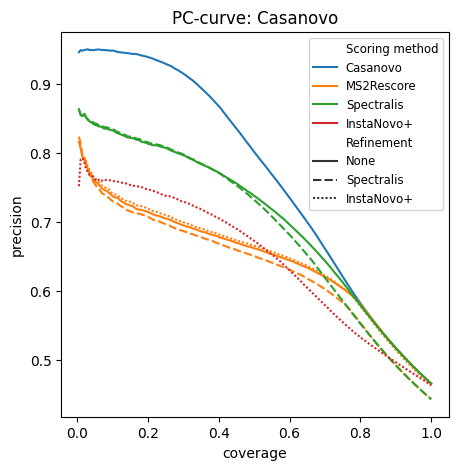

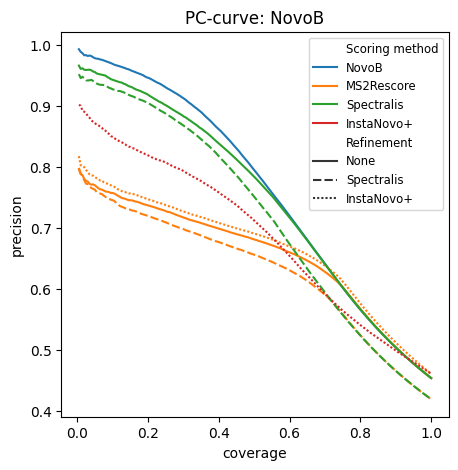

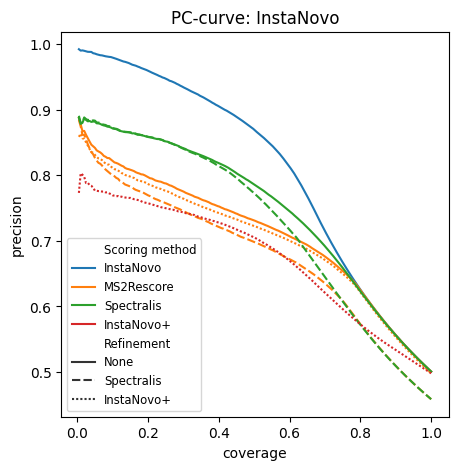

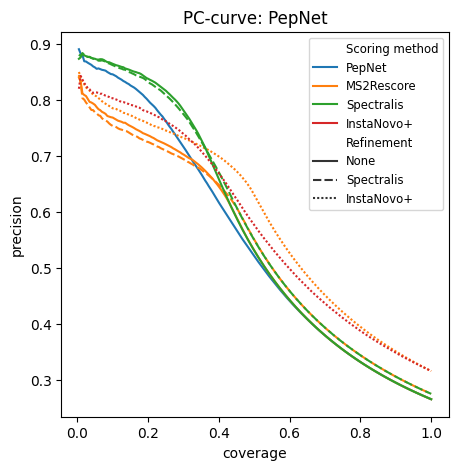

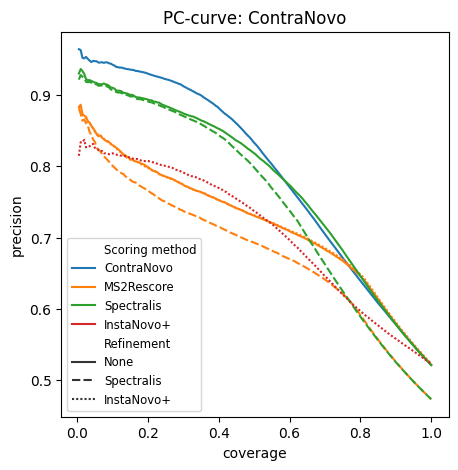

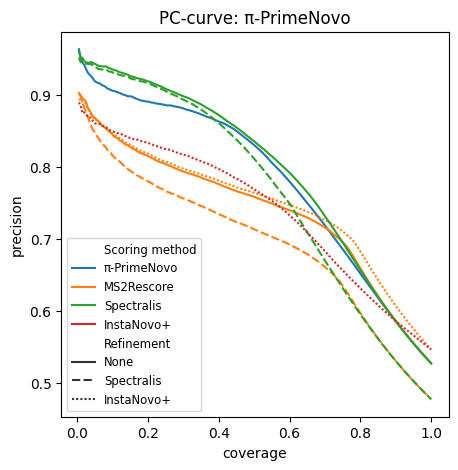

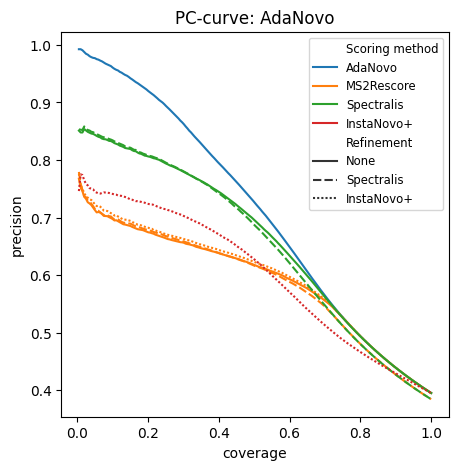

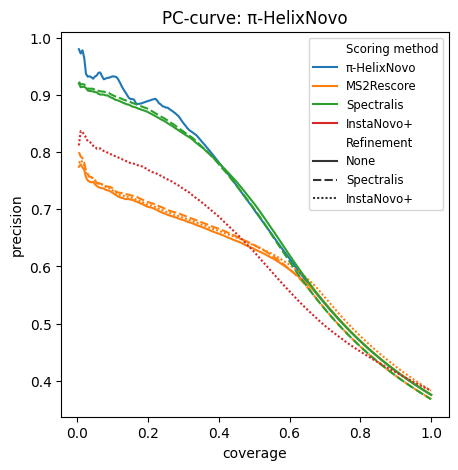

In [46]:
engine_labels = {
    'pepnet': 'PepNet',
    'novob': 'NovoB',
    'instanovo': 'InstaNovo',
    'casanovo': 'Casanovo',
    'contranovo': 'ContraNovo',
    'AdaNovo': 'AdaNovo',
    'pi-PrimeNovo': 'π-PrimeNovo',
    'pi-HelixNovo': 'π-HelixNovo'
}
for engine, score_table in score_tables.items():
    score_table = score_table.copy()
    score_table['Scoring method'] = score_table['Scoring method'].apply(lambda x: x if x not in engine_labels.keys() else engine_labels[engine])
    plt.figure(figsize=(5,5))
    sns.lineplot(
        score_table,
        x='coverage',
        y='precision',
        hue='Scoring method',
        style='Refinement'
    )
    plt.title(f'PC-curve: {engine_labels[engine]}')
    plt.legend(prop={'size': 'small'}) 
    plt.show()

In [ ]:
def plot_pc(ms2rescore, spectralis, instanovoplus, engine_name):
    pc1 = get_prc_curve(
        t=ms2rescore
    )
    pc1['Scoring method'] = 'MS2Rescore'
    pc2 = get_prc_curve(t=spectralis)
    pc2['Scoring method'] = 'Spectralis'
    pc3 = get_prc_curve(t=instanovoplus)
    pc3['Scoring method'] = 'InstaNovo+'

In [28]:
get_prc_curve(
    t=score_tables_ms2rescore['AdaNovo']
)

100%|██████████| 200/200 [00:03<00:00, 51.82it/s]


,precision,recall,coverage
0,0.992497,0.004988,0.005026
1,0.992497,0.009976,0.010051
2,0.990711,0.014937,0.015077
3,0.987674,0.019855,0.020103
4,0.984566,0.024741,0.025128
...,...,...,...
194,0.403089,0.394988,0.979903
195,0.401033,0.394988,0.984928
196,0.398997,0.394988,0.989954
197,0.396981,0.394988,0.994980


In [26]:
score_tables_ms2rescore['AdaNovo']

,spectrum_id,score,match
0,controllerType=0 controllerNumber=1 scan=76784,0.999880,True
1,controllerType=0 controllerNumber=1 scan=61852,0.954905,False
2,controllerType=0 controllerNumber=1 scan=84952,0.987106,False
3,controllerType=0 controllerNumber=1 scan=63146,0.999699,True
4,controllerType=0 controllerNumber=1 scan=44066,0.855992,False
...,...,...,...
185641,controllerType=0 controllerNumber=1 scan=126638,0.814301,False
185642,controllerType=0 controllerNumber=1 scan=102543,-0.001955,False
185643,controllerType=0 controllerNumber=1 scan=70889,-0.158131,False
185644,controllerType=0 controllerNumber=1 scan=67483,0.994242,True


In [5]:
score_dicts = []
for engine in ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo']:
    run_engine =  {run_engine: run.get_common_spectra(engines=[engine]) for run_engine, run in runs.items()}
    n_predicted = sum([len(r.spectra) for r in run_engine.values()])

    seq_score_dict = load_seq_score_dicts(
        runs=run_engine,
        ms2rescore_name='score_ms2rescore',
        denovo_name=engine,
        total_predicted=n_predicted
    )
    score_dicts.append(seq_score_dict)

    # fig, ax = plt.subplots(1,3, figsize=(14,5))
    # fig.suptitle(engine)

    # print("\nCreating plots for", run_engine)

    # error_table = get_refinement_error_tables(run=run_engine, base_engine=engine, score_metadata='score_ms2rescore')
    # plot_refinement_error_table(error_table, fig, ax)

    # plot_precision_recall_refinement(
    #     denovo_seqs=seq_score_dict['denovo_seqs'],
    #     spectralis_seqs=seq_score_dict['spectralis_seqs'],
    #     instanovo_seqs=seq_score_dict['instanovo_seqs'],
    #     denovo_name=engine,
    #     ax=ax[2]
    # )

/home/sam/Work_directory/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:524: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/Work_directory/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:524: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/Work_directory/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:524: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/Work_directory/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:524: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/Work_directory/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:524: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/Work_directory/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:524: RuntimeWarning: invalid value encountered in scalar divide
  pre

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 43077 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).
denovo
plotting casanovo
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


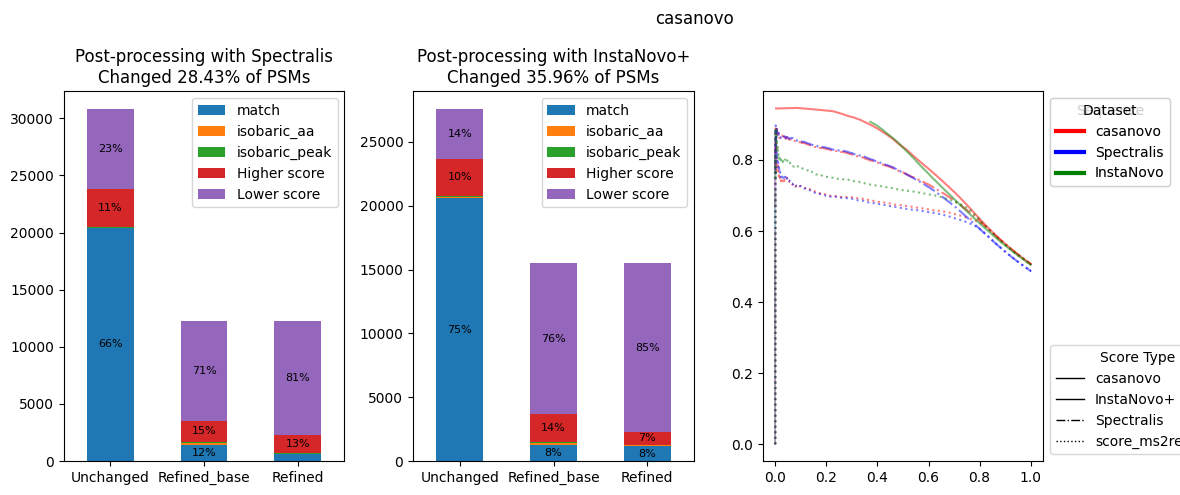

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 42876 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).
denovo
plotting novob
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


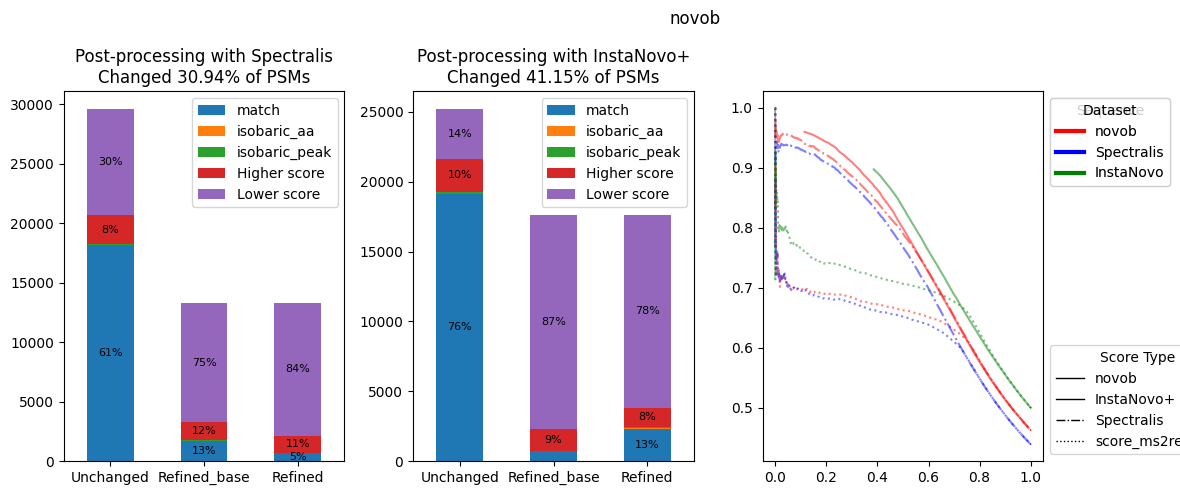

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 43072 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).
denovo
plotting instanovo
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


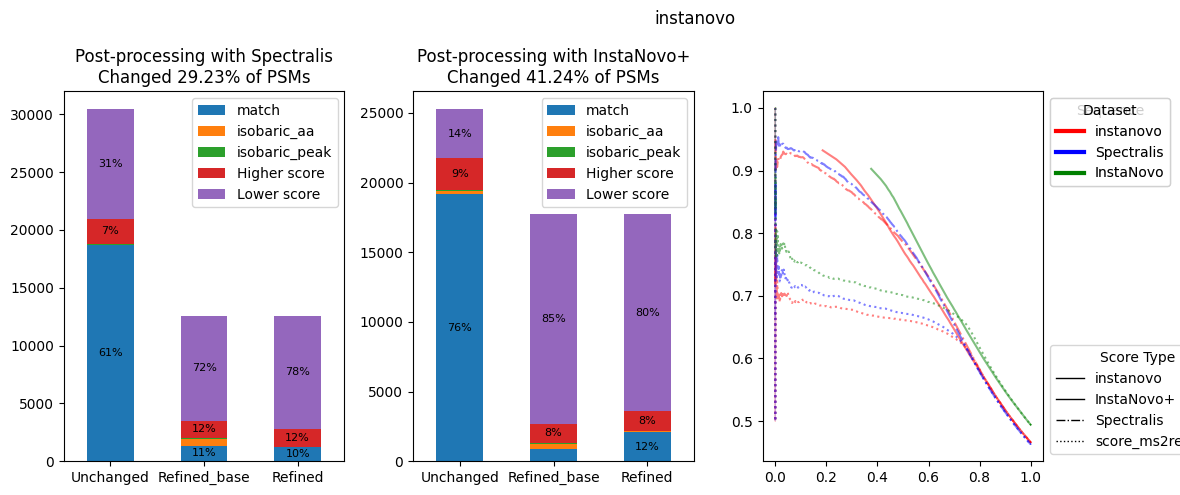

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 43131 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).
denovo
plotting pepnet
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


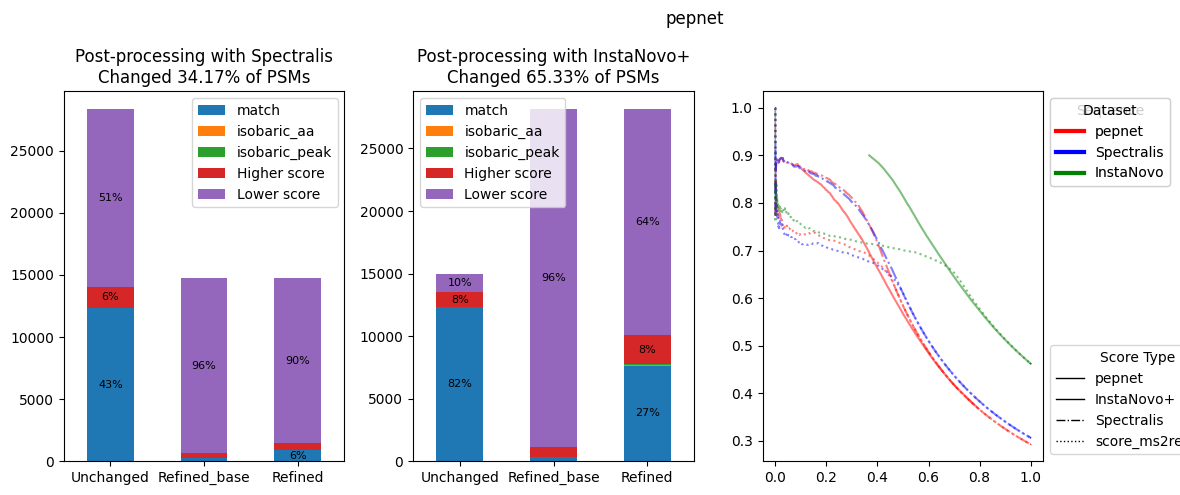

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 21612 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).
denovo
plotting contranovo
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


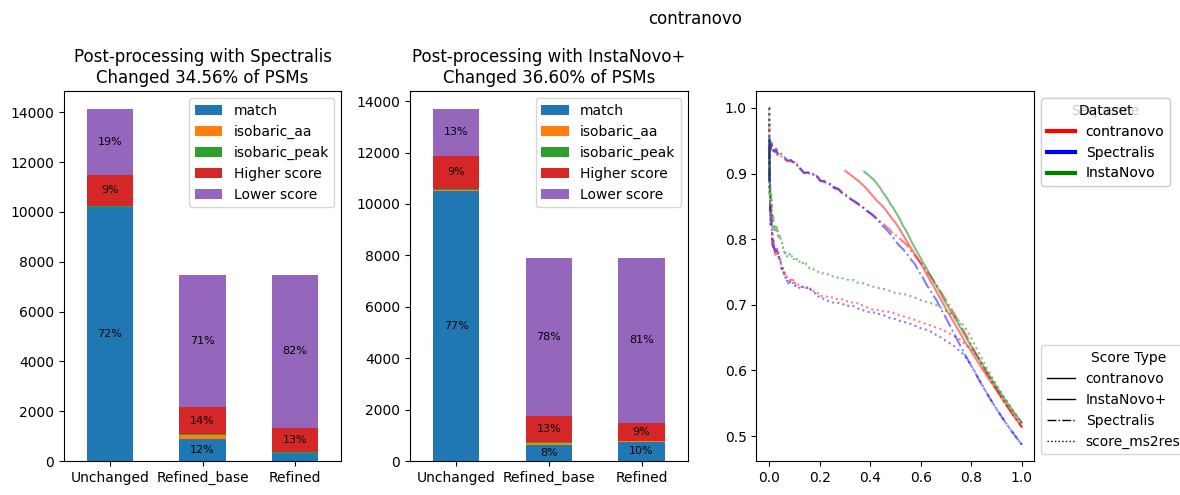

In [ ]:
for engine in ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo']:
    run_engine =  {run_engine: run.get_common_spectra(engines=[engine]) for run_engine, run in runs.items()}
    n_predicted = sum([len(r.spectra) for r in run_engine.values()])

    seq_score_dict = load_seq_score_dicts(
        run=run_engine,
        denovo_name=engine,
        total_predicted=n_predicted
    )

    fig, ax = plt.subplots(1,3, figsize=(14,5))
    fig.suptitle(engine)

    print("\nCreating plots for", run_engine)

    error_table = get_refinement_error_tables(run=run_engine, base_engine=engine, score_metadata='score_ms2rescore')
    plot_refinement_error_table(error_table, fig, ax)

    plot_precision_recall_refinement(
        denovo_seqs=seq_score_dict['denovo_seqs'],
        spectralis_seqs=seq_score_dict['spectralis_seqs'],
        instanovo_seqs=seq_score_dict['instanovo_seqs'],
        denovo_name=engine,
        ax=ax[2]
    )